<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>

<center>
<h3 style="color:#888888;"> <i>--  Introduction à la méthode de Boltzmann sur Réseau  --</i> </h3>
<h1> TP n°4 </h1>
<h3> Modèles de collision Avancés </h3>

<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from numba import jit
import time
fs=20
plt.style.use('ggplot')
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
%matplotlib inline

<h1> Préambule </h1>

Le TP doit être rendu sous la forme d'un Notebook jupyter en respectant la nomenclature suivante:
<center>
<b>TP4_NOM1_NOM2.ipynb</b>
</center>

Tous les résultats, discussions, analyses, doivent donc être inclus dans le fichier.

<h1>Présentation du TP</h1>

On se propose dans ce TP de reprendre les simulations réalisées dans les TP2 et 3 et d'appliquer un modèle de collision avancé de type MRT ou régularisation (au choix). On utilisera dans ce TP le réseau de vitesse D2Q9.


Vous pouvez donc reprendre soit le TP2: *Ecoulement dans une cavité entrainée*, soit le TP3: *Ecoulement autour d'un cylindre* en reprenant également les mêmes conditions aux limites mais en remplacant la collision par un des deux modèles avancés présentés ci-dessous.


On reprend ici le TP3.

<h2>Le modèle à temps de relaxation multiple MRT</h2>

Le principe du modèle MRT est de réaliser l'étape de collision dans l'espace des moments. Pour cela il faut donc définir 9 moments indépendants. La construction de ces moments fait l'objet de nombreux articles et ne sera pas détaillé ici. On donne ici la version classique qui utilise la matrice de passage suivante pour passer des distributions aux moments:

$$
\mathbf{M}=\left(
\begin{array}{ccccccccc}
1&1&1&1&1&1&1&1&1\\
-4&-1&-1&-1&-1&2&2&2&2\\
4&-2&-2&-2&-2&1&1&1&1\\
0&1&0&-1&0&1&-1&-1&1\\
0&-2&0&2&0&1&-1&-1&1\\
0&0&1&0&-1&1&1&-1&-1\\
0&0&-2&0&2&1&1&-1&-1\\
0&1&-1&1&-1&0&0&0&0\\
0&0&0&0&0&1&-1&1&-1\\
\end{array}
\right)
$$

Les moments sont donc obtenus à partir des distributions:

$$
\mathbf{m}=\mathbf{M}\mathbf{g}
$$

et la partie équilibre:

$$
\mathbf{m}^{eq}=\mathbf{M}\mathbf{g}^{eq}
$$

La collision devient alors:

$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha} - \mathbf{M}^{-1}\mathbf{S}[\mathbf{m}-\mathbf{m}^{eq}] }
$$

Où $\mathbf{S}$ est la matrice des temps de relaxation qui peuvent être fixés indépendemment pour chacun des moments. La littérature base le choix de ses temps de relaxation sur une optimisation de la stabilité et donne:

$$
\displaystyle{S=\text{diag}(0,1.05,1.1,0,1.25,0,1.25,1/\tau_g,1/\tau_g)}
$$


In [ ]:
M=np.array([[1,1,1,1,1,1,1,1,1],[-4,-1,-1,-1,-1,2,2,2,2],[4,-2,-2,-2,-2,1,1,1,1],
           [0,1,0,-1,0,1,-1,-1,1],[0,-2,0,2,0,1,-1,-1,1],[0,0,1,0,-1,1,1,-1,-1],
           [0,0,-2,0,2,1,1,-1,-1],[0,1,-1,1,-1,0,0,0,0],[0,0,0,0,0,1,-1,1,-1]])

In [ ]:
ca = np.array([(0,0),(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,-1),(-1,1)]) #nodes

w = [4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36,1/36] #Weights of the quadrature

c0=1/np.sqrt(3) #Normalized celerity sound of the lattice

# Maillage/Domaine
R = 5  # rayon du cylindre
x0, y0= 8*R, 10*R # centre du cylindre
nx = 50*R
ny = 25*R

# Taille de maille:
dx = 1/nx
dy = 1/ny

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

# Vitesse du son réelle à  293K:
c0_real = 330

# Pas de temps:
dt=dx/c0_real*c0

# Mach:
M0=0.3

In [ ]:
def init(M0, Re):
    """
    M0 is the Mach number and Re the Reynolds number.
    Initializes the distribution function, volume density and velocity.
    """
    # Initialisation du domaine
    rho = np.ones((ny,nx))
    geq = np.zeros((9,ny,nx))
    ux = np.zeros((ny,nx))
    uy = np.zeros((ny,nx))

    U0 = M0*c0 #U0 adimensionné -------------------------------
    nu = U0*ny/Re #Viscosity
    ux[:,0] = U0
    taug=1/2 + nu/c0**2

    eq(rho,ux,uy,geq)
    return geq, rho, ux, uy, taug, U0

In [ ]:
def collide(geq,g,M,S):
  collision = np.empty(g.shape)
  g_tmp = np.transpose(g,(1,0,2))
  geq = np.transpose(geq,(1,0,2))
  a = M@g_tmp
  b = M@geq
  diff = S@(a-b)
  collision = np.linalg.solve(M,diff)
  collision = np.transpose(collision, (1,0,2))
  gcoll = g - collision
  return gcoll

In [ ]:
def eq(rho, ux, uy, geq):
    # Mise à  jour de geq
    for i in range(9):
        geq[i] = w[i]*rho*(1 + 3*(ca[i][1]*ux + ca[i][0]*uy) + 9/2*(ca[i][1]*ux + ca[i][0]*uy)**2 - 3/2*(ux**2 + uy**2))

In [ ]:
def propagate(g, gcoll):
  """
  Propagate the distribution function. DO NOT pay attention to boundary conditions for now.
  """
  g[0] = gcoll[0]

  gcoll_shift_r = np.roll(gcoll[1], 1, axis = 1)
  gcoll_shift_r[:,0] = g[1,:,0]
  gcoll_shift_l = np.roll(gcoll[3], -1, axis = 1)
  gcoll_shift_l[:,-1] = g[3,:,-1]
  # Etape de propagation
  g[1] = gcoll_shift_r
  g[3] = gcoll_shift_l

  gcoll_shift_r = np.roll(gcoll[2], -1, axis = 0)
  gcoll_shift_r[-1] = g[2,-1]
  gcoll_shift_l = np.roll(gcoll[4], 1, axis = 0)
  gcoll_shift_l[0] = g[4,0]
  # Etape de propagation
  g[2] = gcoll_shift_r
  g[4] = gcoll_shift_l

  tmp = np.array(g[5,-1], copy = True)
  tmp2 = np.array(g[5,:,0], copy = True)
  g[5] = np.roll(gcoll[5], (-1,1), axis = (0,1))
  g[5,-1] = tmp
  g[5,:,0] = tmp2

  tmp = np.array(g[6,-1], copy = True)
  tmp2 = np.array(g[6,:,-1], copy = True)
  g[6] = np.roll(gcoll[6], (-1,-1), axis = (0,1))
  g[6,-1] = tmp
  g[6,:,-1] = tmp2

  tmp = np.array(g[7,0], copy = True)
  tmp2 = np.array(g[7,:,-1], copy = True)
  g[7] = np.roll(gcoll[7], (1,-1), axis = (0,1))
  g[7,0] = tmp
  g[7,:,-1] = tmp2

  tmp = np.array(g[8,0], copy = True)
  tmp2 = np.array(g[8,:,0], copy = True)
  g[8] = np.roll(gcoll[8], (1,1), axis = (0,1))
  g[8,0] = tmp
  g[8,:,0] = tmp2

In [ ]:
def macro(g,rho,ux,uy):
    # calcul des variables macro
    rho[:,:] = g[0] + g[1] + g[2] + g[3] + g[4] + g[5] + g[6] + g[7] + g[8]
    ux[:,:] = (g[1] - g[3] + g[5] - g[6] - g[7] + g[8])/rho
    uy[:,:] = (g[2] - g[4] + g[5] + g[6] - g[7] - g[8])/rho

In [ ]:
def wall_slip(gcoll,g,mask):
    # Paroi solide sur le cylindre: Bounce back avec frottement
    g[1,mask==1], g[3,mask==1] = gcoll[3,mask==1], gcoll[1,mask==1]
    g[2,mask==1], g[4,mask==1] = gcoll[4,mask==1], gcoll[2,mask==1]
    g[5,mask==1], g[7,mask==1] = gcoll[7,mask==1], gcoll[5,mask==1]
    g[6,mask==1], g[8,mask==1] = gcoll[8,mask==1], gcoll[6,mask==1]

In [ ]:
def inflow(g,rho,ux,uy,M0):
    # Conditions de vitesse au bord gauche
    U0 = M0*c0
    ux[:,0]= U0
    # Macro: On impose ux et on en déduit rho_in
    rho[:,0] = 1/(1-U0)*(2*(g[3,:,0] + g[7,:,0] + g[6,:,0]) + g[2,:,0] + g[4,:,0] + g[0,:,0])

    # Distributions: On impose les distributions inconnues avec le Bounce-Back hors equilibre
    g[1,:,0] = g[3,:,0] + 2/3*U0*rho[:,0]
    g[5,:,0] = g[7,:,0] + 1/6*(U0 + uy[:,0])*rho[:,0]
    g[8,:,0] = g[6,:,0] + 1/6*(U0 - uy[:,0])*rho[:,0]

In [ ]:
def outflow(g,gcoll):
    # Conditions de gradient nul
    # Right
    g[3,:,-1] = g[3,:,-2]
    g[6,:,-1] = g[6,:,-2]
    g[7,:,-1] = g[7,:,-2]
    # Top
    g[7,0,:] = g[7,1,:]
    g[4,0,:] = g[4,1,:]
    g[8,0,:] = g[8,1,:]
    # Bottom
    g[2,-1,:] = g[2,-2,:]
    g[6,-1,:] = g[6,-2,:]
    g[5,-1,:] = g[5,-2,:]

In [ ]:
# Marquage des conditions aux limites:
# Fluide: mask=0
# Solide: mask=1
mask=np.zeros((ny,nx));
mask[y0 - R:y0 + R + 1,x0 - R] = 1
mask[y0 - R : y0 + R + 1,x0 + R] = 1
mask[y0 - R, x0 - R: x0 + R + 1] = 1
mask[y0 + R + 1, x0 - R: x0 + R + 1] = 1

In [ ]:
def dragcoeff(rho,mask,M0):
    Sref = 2*R
    pdyn = 1/2*(M0*c0)**2
    rho_top = np.sum(rho[y0 - R - 1, x0 - R : x0 + R + 1])
    rho_bottom = np.sum(rho[y0 + R + 1, x0 - R: x0 + R + 1])
    return c0**2/(pdyn*Sref)*(rho_top - rho_bottom)

In [ ]:
nt=5000
# Nombre de Reynolds:
Re = [500, 1000, 1500, 2000, 2500, 3000]
Ux = []
Uy = []
Rho = []
Cd_list = []
for re in Re:
  start=time.time()
  # initialisation:
  geq, rho, ux, uy, taug, U0=init(M0,re)
  g, gcoll= geq.copy(), geq.copy()
  Cd=np.zeros(nt)
  S = np.diag([0,1.05,1.1,0,1.25,0,1.25,1/taug,1/taug])
  for it in np.arange(nt):
      gcoll = collide(geq,g,M,S)
      propagate(g, gcoll)

      wall_slip(gcoll,g,mask)
      inflow(g,rho,ux,uy,M0)
      outflow(g,gcoll)

      macro(g,rho,ux,uy) #
      eq(rho,ux,uy,geq) #Update geq

      Cd[it] = dragcoeff(rho,mask,M0)
  tcal=time.time()-start
  Ux += [ux]
  Uy += [uy]
  Rho += [rho]
  Cd_list += [Cd]
  mlups=nx*ny*1e-6*nt/tcal
  print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+str(mlups)+"  MLUPS")

5000 itérations en 123.93303561210632s: Performances: 1.2607615009854307  MLUPS
5000 itérations en 117.79769849777222s: Performances: 1.326426594004763  MLUPS
5000 itérations en 117.17335867881775s: Performances: 1.33349424956141  MLUPS
5000 itérations en 114.38666772842407s: Performances: 1.3659808708735839  MLUPS
5000 itérations en 117.55471587181091s: Performances: 1.3291682842429295  MLUPS
5000 itérations en 116.14745497703552s: Performances: 1.3452726969428084  MLUPS


Text(0.5, 0, 'Time')

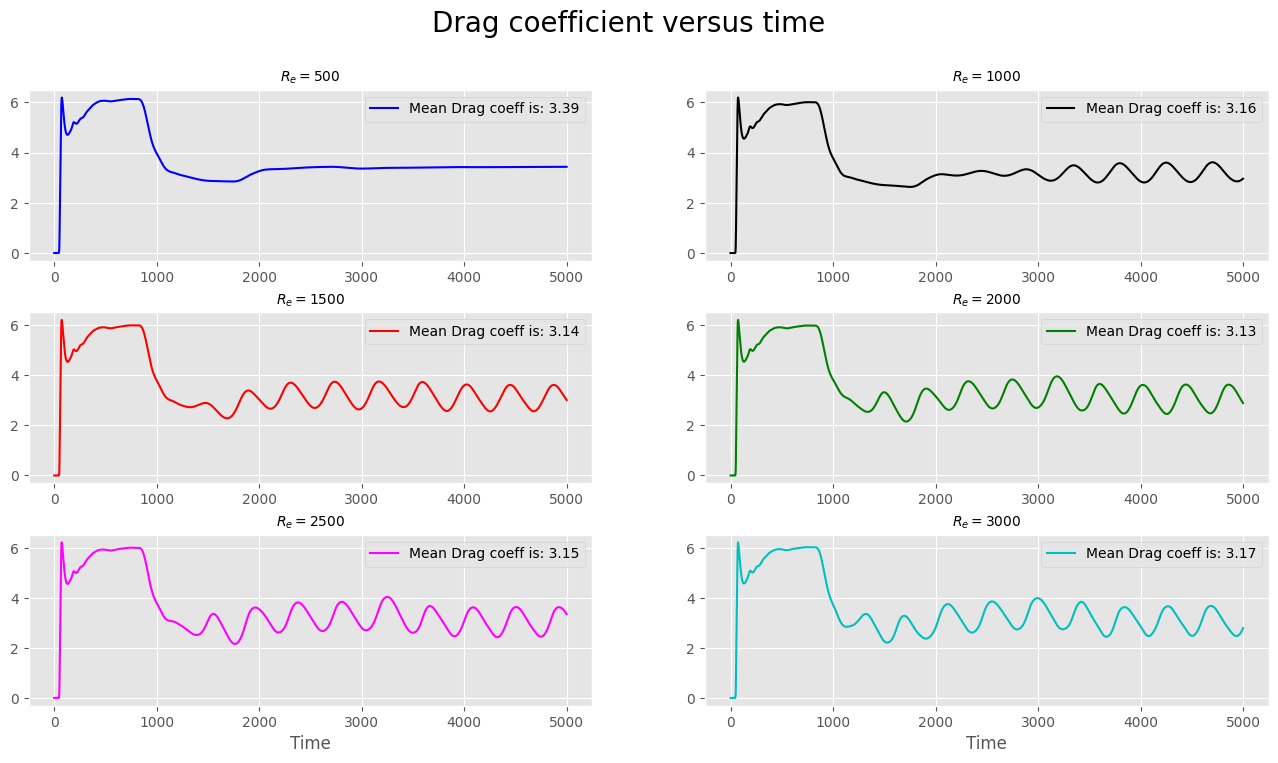

In [ ]:
import statistics
fig, ax = plt.subplots(3,2, figsize = (16,8))
plt.subplots_adjust(hspace = .3)
fig.suptitle("Drag coefficient versus time", fontsize = 20)
color = ['b', 'black', 'r', 'g', 'magenta', 'c']
for i in range(6):
  ax_ = ax[i//2][i%2]
  mean = statistics.mean(Cd_list[i][2000:])
  ax_.set_title(f"$R_e = $" + str(Re[i]), fontsize = 10)
  ax_.plot(Cd_list[i], label = f"Mean Drag coeff is: " + str(mean)[:4], color = color[i])
  ax_.tick_params(axis = 'x', labelsize = '10')
  ax_.tick_params(axis = 'y', labelsize = '10')
  ax_.legend()

ax[2,0].set_xlabel("Time")
ax[2,1].set_xlabel("Time")

In [ ]:
OmegaZ=np.zeros((len(Re),ny,nx))
for r in range(len(Re)):
  ux = Ux[r]
  uy = Uy[r]
  for i in range(ny-1):
      for j in range(nx-1):
          OmegaZ[r,i,j]= (uy[i,j + 1] - uy[i,j])/dx - (ux[i+1,j] - ux[i,j])/dy

Text(0, 0.5, 'y')

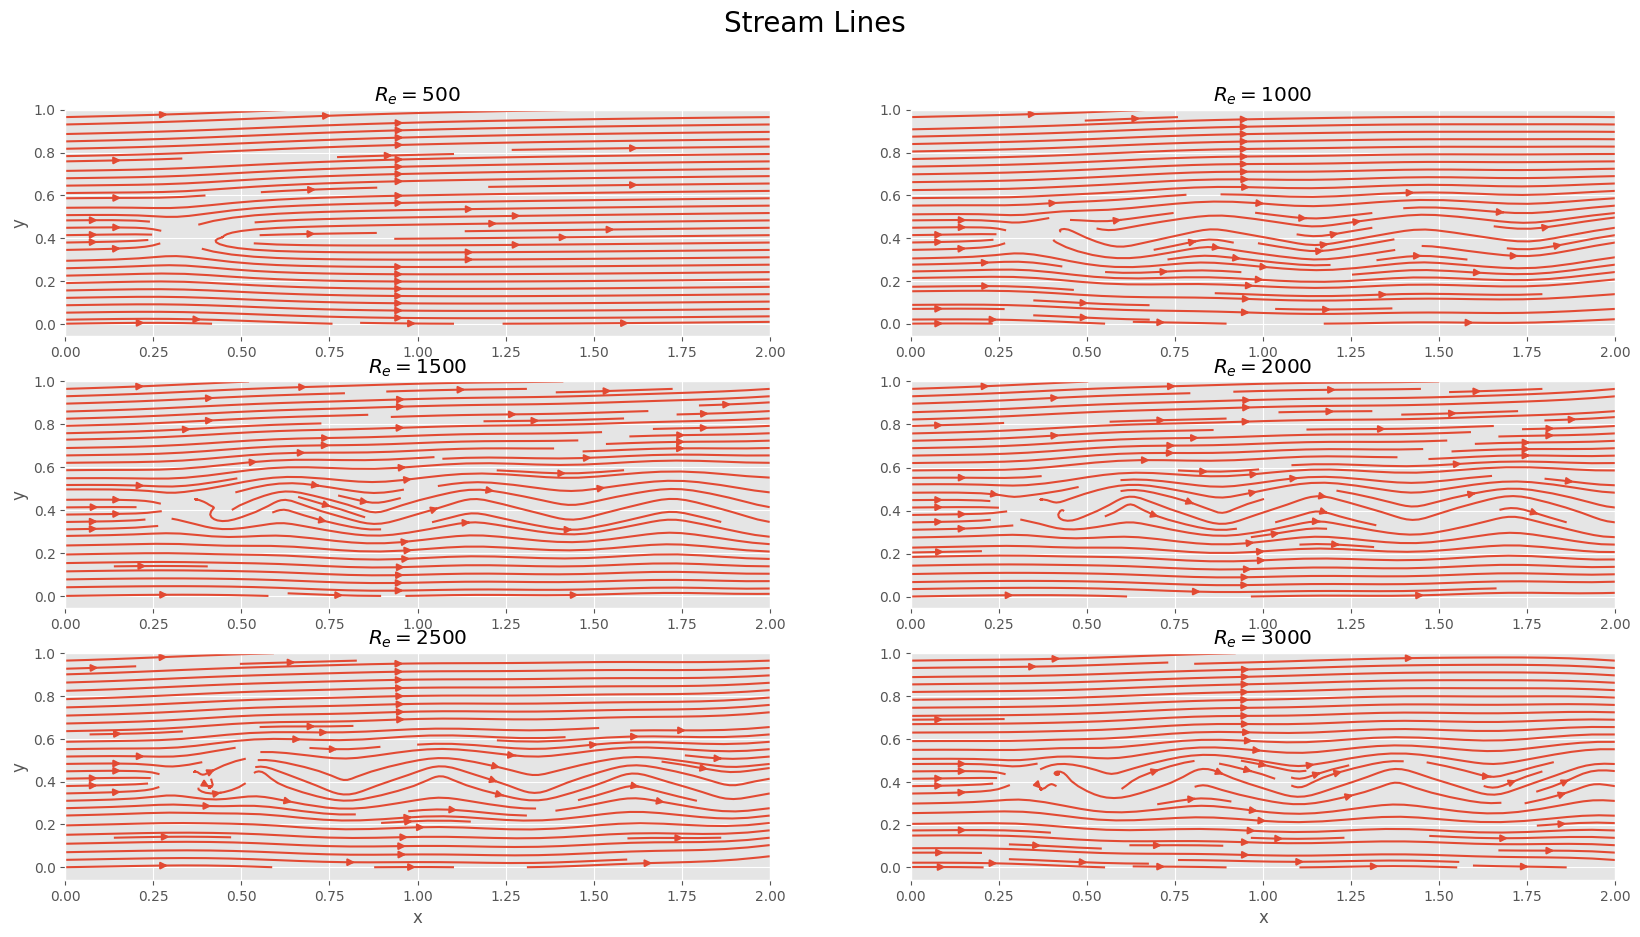

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (20,10))
plt.subplots_adjust(hspace = .2)
fig.suptitle("Stream Lines", fontsize = 20)
for i in range(6):
  ax_i = ax[i//2,i%2]
  ux = Ux[i]
  uy = Uy[i]
  ax_i.streamplot(x,y,ux,uy)
  ax_i.set_title(f"$R_e = $" + str(Re[i]))
  ax_i.tick_params(axis = 'x', labelsize = 10)
  ax_i.tick_params(axis = 'y', labelsize = 10)
ax[2,0].set_xlabel("x")
ax[2,1].set_xlabel("x")

ax[0,0].set_ylabel("y")
ax[1,0].set_ylabel("y")
ax[2,0].set_ylabel("y")

Text(0, 0.5, 'y')

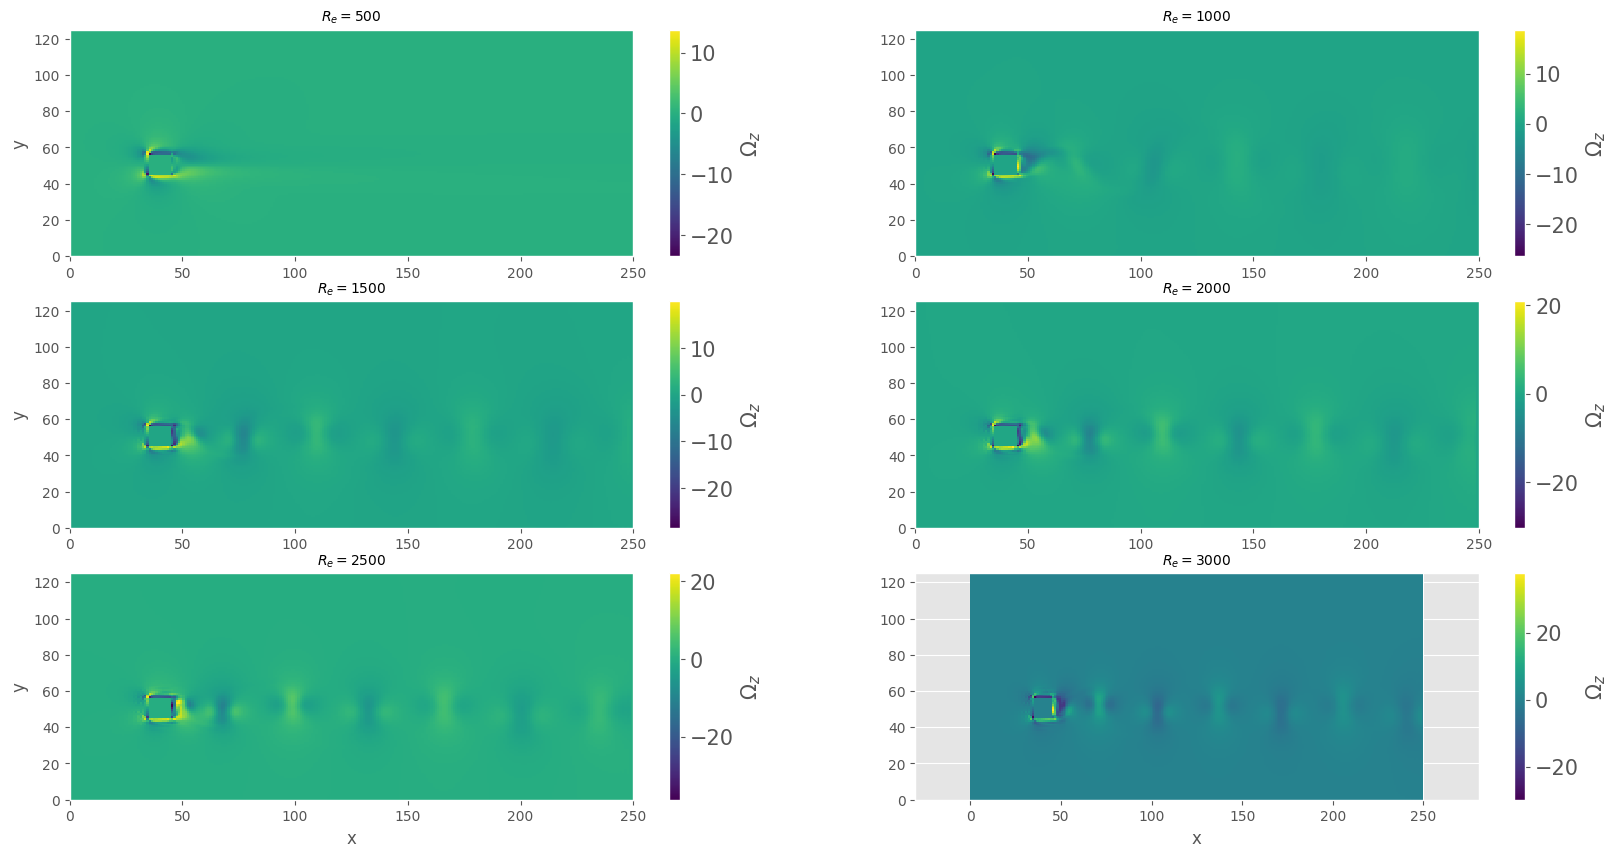

In [ ]:
fig, ax = plt.subplots(3,2,figsize = (20,10))
plt.subplots_adjust(hspace = .2)
for i in range(6):
  ax_i = ax[i//2][i%2]
  map = ax_i.pcolormesh(OmegaZ[i], cmap = 'viridis')
  cb = plt.colorbar(map, ax = ax_i)
  cb.set_label(f'$\Omega_z$', fontsize=15)
  cb.ax.tick_params(labelsize=15)
  ax_i.set_title(f"$R_e =$" + str(Re[i]), fontsize = 10)
  ax_i.tick_params(axis = 'x', labelsize = 10)
  ax_i.tick_params(axis = 'y', labelsize = 10)
  plt.axis('equal')

ax[2,0].set_xlabel("x")
ax[2,1].set_xlabel("x")

ax[0,0].set_ylabel("y")
ax[1,0].set_ylabel("y")
ax[2,0].set_ylabel("y")

<h2>Le modèle régularisé</h2>

Le principe du modèle régularisé est de reconstruire la partie hors équilibre en utilisant une estimation à l'aide du tenseur de cisaillement $S_{ij}$ calculé à l'ordre 2 par différences finies:

$$      
\displaystyle{g_\alpha^{heq}=-\dfrac{\omega_\alpha \rho \tau_g \Delta t}{c_0^2}H^\alpha_{ij}S_{ij}}
$$


**Attention** ici il y a bien sommation sur i et j: $H^\alpha_{ij}S_{ij}=H^\alpha_{11}S_{11}+H^\alpha_{12}S_{12}+H^\alpha_{21}S_{21}+H^\alpha_{22}S_{22}$.

Avec:

$$
H^\alpha_{ij}=c_{\alpha,i}c_{\alpha,j}-c_0^2 \delta_{ij}
$$

et

$$
\displaystyle{S_{ij}=\dfrac{1}{2}\left( \dfrac{\partial u_i}{\partial x_j}+\dfrac{\partial u_j}{\partial x_i} \right)}
$$

En remplacant $g$ par $g^{eq}+g^{heq}$, dans l'étape de collision BGK, la nouvelle collision devient:

$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha}^{eq}+ \left(1-\dfrac{dt}{\tau_g}\right)g_{\alpha}^{heq}}
$$

**Note:** On pourra utiliser la fonction <a href="https://numpy.org/doc/stable/reference/generated/numpy.gradient.html">*gradient*</a> de numpy pour évaluer les composante de $S_{ij}$ par différence finie.

In [ ]:
def S_ij(St,ux,uy):
    """
    Calcul du tenseur de cisaillement
    """
    duxdx = np.gradient(ux,dx,axis = 1)
    duxdy = np.gradient(ux,dy,axis = 0)
    duydx = np.gradient(uy,dx,axis = 1)
    duydy = np.gradient(uy,dy,axis = 0)

    St[0] = duxdx
    St[1] = 1/2*(duxdy + duydx)
    St[2] = duydy
    St[3] = 1/2*(duydx + duxdy)

In [ ]:
def hors_eq(gheq,rho,St,H):
    """
    Mise a jour de la partie hors equilibre
    """
    term = rho*taug*dt/c0**2
    for i in range(9):
      gheq[i] = - w[i]*term*(H[i,0,0]*St[0] + H[i,0,1]*St[1] + H[i,1,0]*St[2] + H[i,1,1]*St[3])

In [ ]:
def init_heq(rho, ux, uy):
    '''
    Initialisation de la partie hors eq
    '''
    St = np.zeros((4,ny,nx))
    S_ij(St,ux,uy)
    gheq = np.zeros((9,ny,nx))
    hors_eq(gheq,rho,St, H)
    return St, gheq

In [ ]:
def collision(geq,gheq):
    """
    Mise a jour de la collision régularisé
    """
    gcoll = geq + (1 - 1/taug)*gheq
    return gcoll

In [ ]:
nt=5000
# Nombre de Reynolds:
Re = [500, 1000, 1500, 2000, 2500, 3000]

Ux = []
Uy = []
Rho = []
Cd_list = []

#Constant tensor
H = np.empty((9,2,2))
for i in range(9):
  H[i] = [[ca[i,0]**2 - c0**2, ca[i,0]*ca[i,1]], [ca[i,1]*ca[i,0], ca[i,1]**2 - c0**2]]

for re in Re:
  start=time.time()

  # initialisation:
  geq, rho, ux, uy, taug, U0 = init(M0,re)
  St, gheq = init_heq(rho, ux, uy)
  g, gcoll = geq.copy(), geq.copy()

  Cd=np.zeros(nt)
  for it in np.arange(nt):

      gcoll = collision(geq, gheq)
      propagate(g, gcoll)

      wall_slip(gcoll,g,mask)
      inflow(g,rho,ux,uy,M0)
      outflow(g,gcoll)

      macro(g,rho,ux,uy)
      eq(rho,ux,uy,geq) #Update geq

      S_ij(St,ux,uy) #Update Stress tensor
      hors_eq(gheq, rho, St, H) #Update g_heq

      Cd[it] = dragcoeff(rho,mask,M0)

  tcal=time.time()-start
  Ux += [ux]
  Uy += [uy]
  Rho += [rho]
  Cd_list += [Cd]
  mlups=nx*ny*1e-6*nt/tcal
  print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+ str(mlups)+"  MLUPS")

5000 itérations en 62.56498742103577s: Performances: 2.4974032033044926  MLUPS
5000 itérations en 59.40479016304016s: Performances: 2.6302592698528535  MLUPS
5000 itérations en 62.28667974472046s: Performances: 2.5085620334939116  MLUPS
5000 itérations en 58.52780294418335s: Performances: 2.669671372236749  MLUPS
5000 itérations en 60.46528172492981s: Performances: 2.584127544643163  MLUPS
5000 itérations en 58.14588904380798s: Performances: 2.687206311047698  MLUPS


Text(0.5, 0, 'Time')

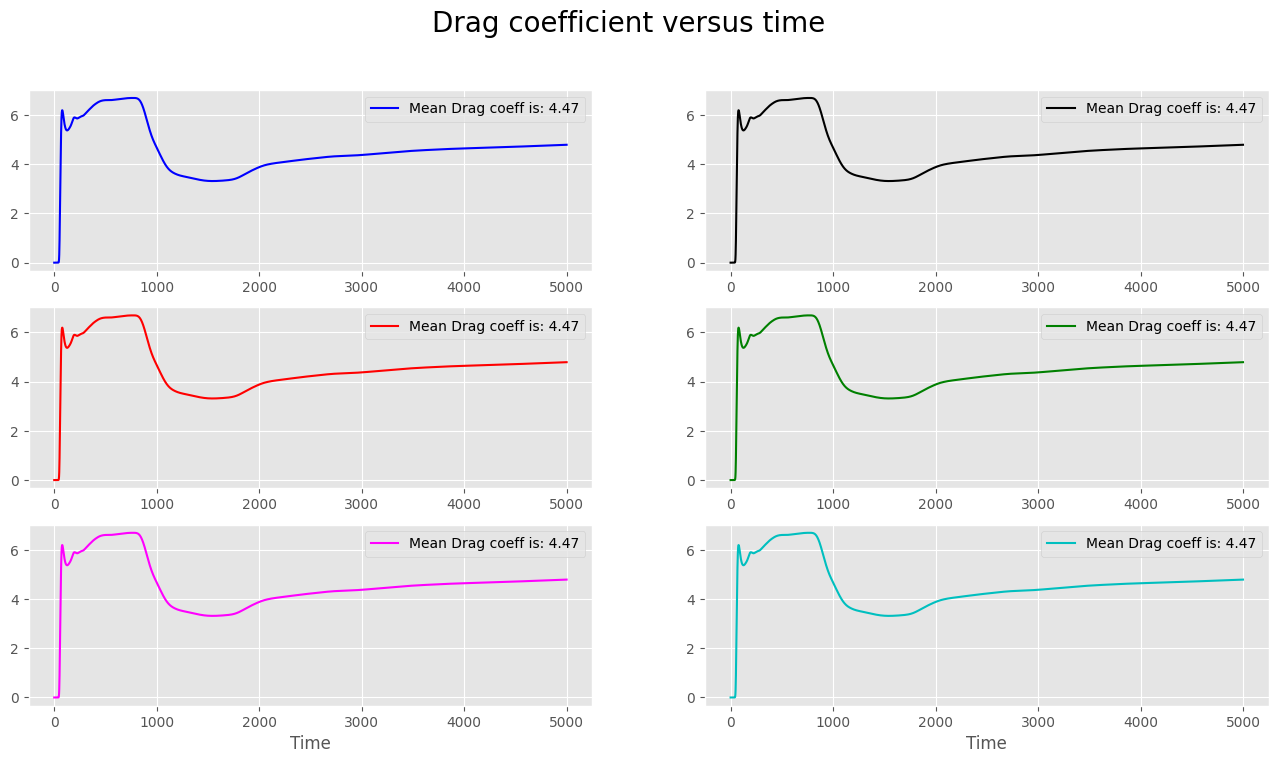

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (16,8))
plt.subplots_adjust(hspace = .2)
fig.suptitle("Drag coefficient versus time", fontsize = 20)
color = ['b', 'black', 'r', 'g', 'magenta', 'c']
for i in range(6):
  ax_ = ax[i//2][i%2]
  mean = statistics.mean(Cd_list[i][2000:])
  ax_.plot(Cd_list[i], label = f"Mean Drag coeff is: " + str(mean)[:4], color = color[i])
  ax_.tick_params(axis = 'x', labelsize = '10')
  ax_.tick_params(axis = 'y', labelsize = '10')
  ax_.legend()

ax[2,0].set_xlabel("Time")
ax[2,1].set_xlabel("Time")

In [ ]:
OmegaZ=np.zeros((len(Re),ny,nx))
for r in range(len(Re)):
  ux = Ux[r]
  uy = Uy[r]
  for i in range(ny-1):
      for j in range(nx-1):
          OmegaZ[r,i,j]= (uy[i,j + 1] - uy[i,j])/dx - (ux[i+1,j] - ux[i,j])/dy


Text(0, 0.5, 'y')

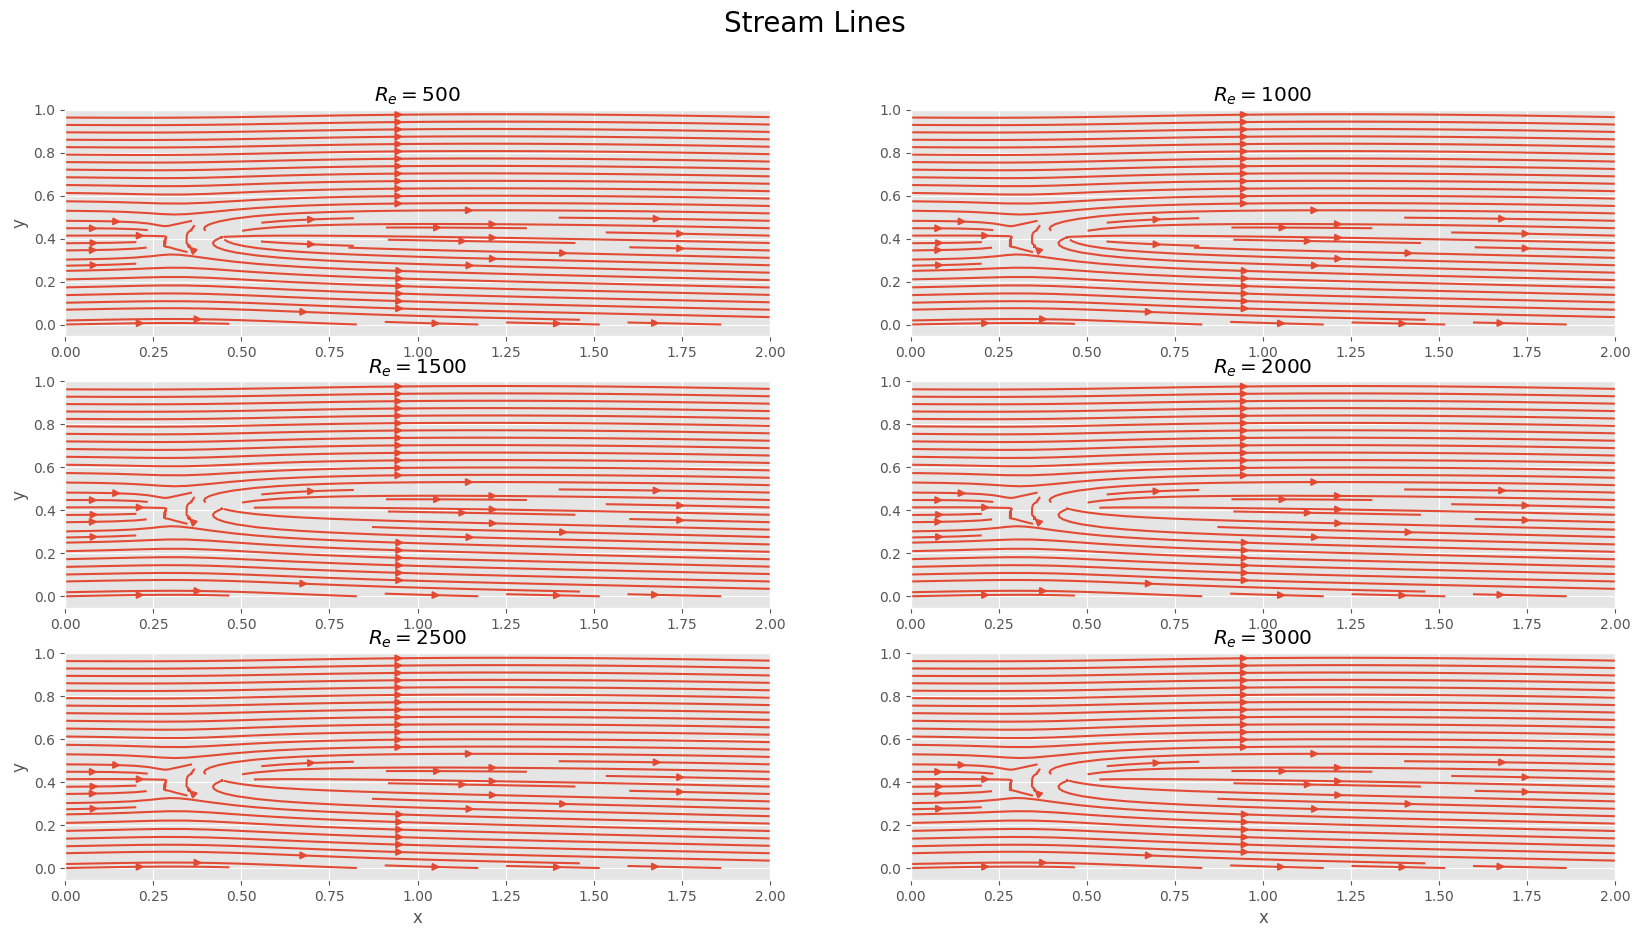

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (20,10))
plt.subplots_adjust(hspace = .2)
fig.suptitle("Stream Lines", fontsize = 20)
for i in range(6):
  ax_i = ax[i//2,i%2]
  ux = Ux[i]
  uy = Uy[i]
  ax_i.streamplot(x,y,ux,uy)
  ax_i.set_title(f"$R_e = $" + str(Re[i]))
  ax_i.tick_params(axis = 'x', labelsize = 10)
  ax_i.tick_params(axis = 'y', labelsize = 10)
ax[2,0].set_xlabel("x")
ax[2,1].set_xlabel("x")

ax[0,0].set_ylabel("y")
ax[1,0].set_ylabel("y")
ax[2,0].set_ylabel("y")

Text(0, 0.5, 'y')

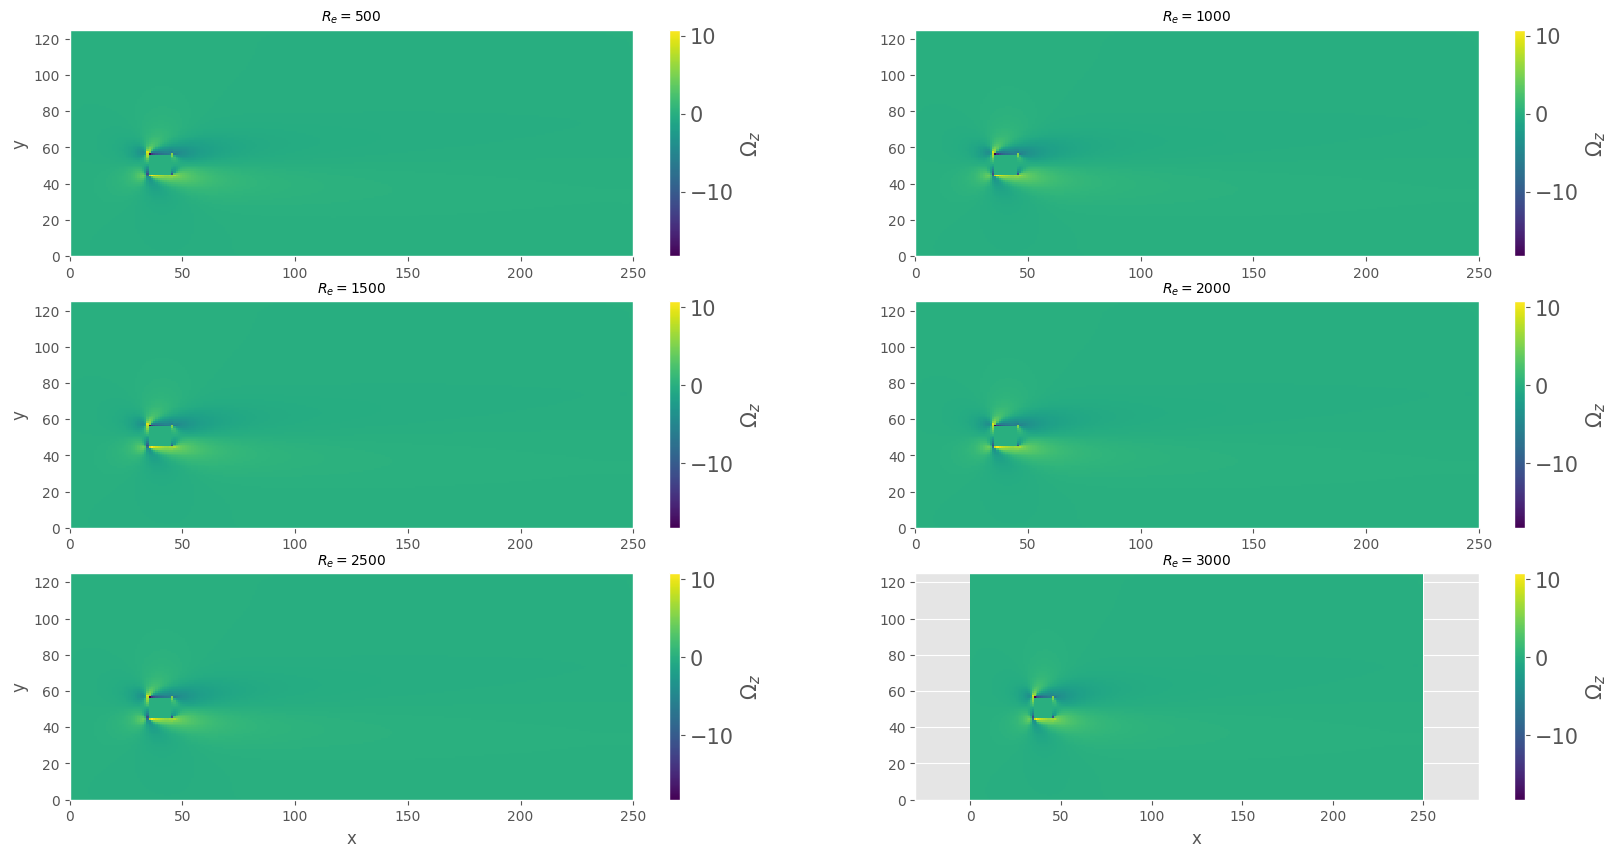

In [ ]:
fig, ax = plt.subplots(3,2,figsize = (20,10))
plt.subplots_adjust(hspace = .2)
for i in range(6):
  ax_i = ax[i//2][i%2]
  map = ax_i.pcolormesh(OmegaZ[i], cmap = 'viridis')
  cb = plt.colorbar(map, ax = ax_i)
  cb.set_label(f'$\Omega_z$', fontsize=15)
  cb.ax.tick_params(labelsize=15)
  ax_i.set_title(f"$R_e =$" + str(Re[i]), fontsize = 10)
  ax_i.tick_params(axis = 'x', labelsize = 10)
  ax_i.tick_params(axis = 'y', labelsize = 10)
  plt.axis('equal')

ax[2,0].set_xlabel("x")
ax[2,1].set_xlabel("x")

ax[0,0].set_ylabel("y")
ax[1,0].set_ylabel("y")
ax[2,0].set_ylabel("y")

<h1>Travail demandé</h1>

En reprenant les mêmes conditions initiales et les mêmes conditions aux limites que dans le TP2 ou 3, implémentez une des deux collisions avancées pour effectuer des calculs pour des plus grand nombre de Reynolds.

Comparez vos résultats à ceux obtenus pour la collision BGK.

# Conclusion

Présenter ici la synthèse de votre TP en décrivant les points importants et les principaux résultats.


In [ ]:
from IPython.core.display import HTML
style=open('notebooks.css', "r").read()
HTML(style)

<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>
<center><a href="#top">Retour en haut de la page</a></center>